# User Case Study: Tracking a User Through the Pipeline

This notebook demonstrates the entire depression detection pipeline for a single user, showing each step for presentation purposes.

**Selected User:** `test_subject7921`
- Ground truth: **Positive (depressed)**
- Model prediction: **Correct**
- Confidence: **54.5%**

**Pipeline Steps:**
1. Load raw posts from XML
2. SBERT encoding of posts and concepts
3. MAX-based post retrieval (select top-50 posts)
4. Attention pooling (create user embedding)
5. CEM inference (concept predictions + final prediction)

## Section 0: Setup & Load User Posts

In [1]:
# Imports
import os
import glob
import re
import zipfile
import tempfile
import shutil

import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET

import torch
import torch.nn as nn
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer, util

import matplotlib.pyplot as plt
import seaborn as sns

print("All imports successful")

/opt/miniconda3/envs/38concept_embedding/lib/python3.8/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


All imports successful


In [2]:
# Configuration
TARGET_USER = "test_subject7921"  # Our selected positive user

# Paths
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
DATA_RAW = os.path.join(PROJECT_ROOT, "data/raw")
TEST_DIR = os.path.join(DATA_RAW, "test")
TEST_LABELS = os.path.join(TEST_DIR, "test_golden_truth.txt")
MODEL_CHECKPOINT = "outputs_cem_max_gold/models/cem-max-gold-epoch=11-val_loss=0.87.ckpt"

# Device
if torch.backends.mps.is_available():
    DEVICE = "mps"
elif torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

print(f"Target User: {TARGET_USER}")
print(f"Device: {DEVICE}")

Target User: test_subject7921
Device: mps


In [3]:
# Define 21 BDI-II concept names
CONCEPT_NAMES = [
    "Sadness", "Pessimism", "Past failure", "Loss of pleasure",
    "Guilty feelings", "Punishment feelings", "Self-dislike", "Self-criticalness",
    "Suicidal thoughts or wishes", "Crying", "Agitation", "Loss of interest",
    "Indecisiveness", "Worthlessness", "Loss of energy", "Changes in sleeping pattern",
    "Irritability", "Changes in appetite", "Concentration difficulty",
    "Tiredness or fatigue", "Loss of interest in sex"
]
N_CONCEPTS = len(CONCEPT_NAMES)

print(f"Defined {N_CONCEPTS} BDI-II concepts:")
for i, name in enumerate(CONCEPT_NAMES, 1):
    print(f"  {i:2d}. {name}")

Defined 21 BDI-II concepts:
   1. Sadness
   2. Pessimism
   3. Past failure
   4. Loss of pleasure
   5. Guilty feelings
   6. Punishment feelings
   7. Self-dislike
   8. Self-criticalness
   9. Suicidal thoughts or wishes
  10. Crying
  11. Agitation
  12. Loss of interest
  13. Indecisiveness
  14. Worthlessness
  15. Loss of energy
  16. Changes in sleeping pattern
  17. Irritability
  18. Changes in appetite
  19. Concentration difficulty
  20. Tiredness or fatigue
  21. Loss of interest in sex


In [4]:
# Helper functions
WHITESPACE_RE = re.compile(r"\s+")

def normalize_text(text):
    """Normalize text by removing null chars and extra whitespace."""
    if not text:
        return ""
    text = text.replace("\u0000", "")
    text = WHITESPACE_RE.sub(" ", text).strip()
    return text

def extract_posts_from_xml(xml_path, min_chars=10):
    """Extract posts from a single XML file."""
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
    except Exception as e:
        print(f"WARNING: Failed to parse {xml_path}: {e}")
        return []
    
    posts = []
    for writing in root.findall("WRITING"):
        title = writing.findtext("TITLE") or ""
        text = writing.findtext("TEXT") or ""
        
        combined = normalize_text(f"{title} {text}".strip())
        if len(combined) >= min_chars:
            posts.append(combined)
    
    return posts

print("Helper functions defined")

Helper functions defined


In [5]:
# Load user's ground truth label
test_labels_df = pd.read_csv(TEST_LABELS, sep='\t', header=None, names=['subject_id', 'label'])
test_labels_df['subject_id'] = test_labels_df['subject_id'].str.strip()

user_label = test_labels_df[test_labels_df['subject_id'] == TARGET_USER]['label'].iloc[0]

print("="*70)
print(f"USER INFORMATION: {TARGET_USER}")
print("="*70)
print(f"Ground Truth Label: {user_label} ({'DEPRESSED' if user_label == 1 else 'CONTROL'})")

USER INFORMATION: test_subject7921
Ground Truth Label: 1 (DEPRESSED)


In [6]:
# Extract test ZIP files and find user's posts
print("\nExtracting test data to find user's posts...")

temp_dir = tempfile.mkdtemp(prefix="test_chunks_")
print(f"Temp directory: {temp_dir}")

for i in range(1, 11):
    zip_path = os.path.join(TEST_DIR, f"chunk {i}.zip")
    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(os.path.join(temp_dir, f"chunk_{i}"))

print("Test data extracted")


Extracting test data to find user's posts...
Temp directory: /var/folders/gb/m6c_r5xx6_14p7mlfjwk29900000gn/T/test_chunks_s__al_wu
Test data extracted


In [7]:
# Find and load user's posts
user_posts = []

user_xml_files = glob.glob(os.path.join(temp_dir, "**", f"{TARGET_USER}_*.xml"), recursive=True)

print(f"\nFound {len(user_xml_files)} XML files for {TARGET_USER}")

for xml_file in user_xml_files:
    posts = extract_posts_from_xml(xml_file)
    user_posts.extend(posts)

print(f"Total posts extracted: {len(user_posts)}")


Found 10 XML files for test_subject7921
Total posts extracted: 229


In [8]:
# Display sample posts
print("\n" + "="*70)
print("SAMPLE USER POSTS (First 5)")
print("="*70)

for i, post in enumerate(user_posts[:5], 1):
    print(f"\nPost {i}:")
    print("-" * 40)
    print(post[:500] + ("..." if len(post) > 500 else ""))
    print(f"[Length: {len(post)} characters]")


SAMPLE USER POSTS (First 5)

Post 1:
----------------------------------------
History says this poster is a male.
[Length: 35 characters]

Post 2:
----------------------------------------
Let's see some red marks on one of those cheeks.
[Length: 48 characters]

Post 3:
----------------------------------------
Lovely, really like the outfit. Now just needs spanked for being so naughty.
[Length: 76 characters]

Post 4:
----------------------------------------
Awesome as always.
[Length: 18 characters]

Post 5:
----------------------------------------
Depends how long she was a friend, or if you liked her as a friend before things went downhill. Not to say she was right, but depressed people can emotionally manipulate even if they aren't intending it. I know I used to focus on one person or two and think they were the solution to my sadness, if only they would.........insert whatever Im the same with conversations, even with my depression improved some... And honestly people get kind of 

In [9]:
# Post statistics
post_lengths = [len(p) for p in user_posts]
word_counts = [len(p.split()) for p in user_posts]

print("\n" + "="*70)
print("USER POST STATISTICS")
print("="*70)
print(f"Total posts: {len(user_posts)}")
print(f"\nCharacter counts:")
print(f"  Min: {min(post_lengths)}")
print(f"  Max: {max(post_lengths)}")
print(f"  Mean: {np.mean(post_lengths):.1f}")
print(f"  Median: {np.median(post_lengths):.1f}")
print(f"\nWord counts:")
print(f"  Min: {min(word_counts)}")
print(f"  Max: {max(word_counts)}")
print(f"  Mean: {np.mean(word_counts):.1f}")
print(f"  Median: {np.median(word_counts):.1f}")


USER POST STATISTICS
Total posts: 229

Character counts:
  Min: 10
  Max: 7514
  Mean: 512.4
  Median: 262.0

Word counts:
  Min: 1
  Max: 1423
  Mean: 94.0
  Median: 48.0


## Section 1: SBERT Encoding

In [10]:
# Load SBERT model
print("Loading SBERT model: all-MiniLM-L6-v2")
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
sbert_model = sbert_model.to(DEVICE)

print(f"\nSBERT model loaded on {DEVICE}")
print(f"Embedding dimension: {sbert_model.get_sentence_embedding_dimension()}")

Loading SBERT model: all-MiniLM-L6-v2

SBERT model loaded on mps
Embedding dimension: 384


In [11]:
# Create concept embeddings
print("\n" + "="*70)
print("CREATING CONCEPT EMBEDDINGS")
print("="*70)

concept_embeddings = sbert_model.encode(
    CONCEPT_NAMES,
    convert_to_tensor=True,
    show_progress_bar=False
)

print(f"\nConcept embeddings shape: {concept_embeddings.shape}")
print(f"  - {N_CONCEPTS} concepts")
print(f"  - {concept_embeddings.shape[1]} dimensions per concept")


CREATING CONCEPT EMBEDDINGS

Concept embeddings shape: torch.Size([21, 384])
  - 21 concepts
  - 384 dimensions per concept


## Section 2: Post Retrieval (MAX-based)

In [12]:
# Encode all user posts
print("\n" + "="*70)
print("ENCODING ALL USER POSTS")
print("="*70)

print(f"\nEncoding {len(user_posts)} posts...")

with torch.no_grad():
    post_embeddings = sbert_model.encode(
        user_posts,
        convert_to_tensor=True,
        show_progress_bar=True
    )

print(f"\nPost embeddings shape: {post_embeddings.shape}")
print(f"  - {post_embeddings.shape[0]} posts")
print(f"  - {post_embeddings.shape[1]} dimensions per post")


ENCODING ALL USER POSTS

Encoding 229 posts...


Batches:   0%|          | 0/8 [00:00<?, ?it/s]


Post embeddings shape: torch.Size([229, 384])
  - 229 posts
  - 384 dimensions per post


In [13]:
# Compute similarity to concepts
print("\n" + "="*70)
print("COMPUTING SIMILARITY TO CONCEPTS")
print("="*70)

with torch.no_grad():
    # Compute cosine similarity between each post and each concept
    similarity_matrix = util.cos_sim(post_embeddings, concept_embeddings)  # [n_posts, 21]

print(f"\nSimilarity matrix shape: {similarity_matrix.shape}")
print(f"  - {similarity_matrix.shape[0]} posts")
print(f"  - {similarity_matrix.shape[1]} concepts")


COMPUTING SIMILARITY TO CONCEPTS

Similarity matrix shape: torch.Size([229, 21])
  - 229 posts
  - 21 concepts


In [14]:
# Take MAX similarity per post (key difference in this pipeline)
print("\n" + "="*70)
print("MAX-BASED SCORING")
print("="*70)

# For each post, get the MAX similarity across all concepts
max_similarities, best_concept_indices = similarity_matrix.max(dim=1)
max_similarities = max_similarities.cpu().numpy()
best_concept_indices = best_concept_indices.cpu().numpy()

print("\nFor each post, we take the MAXIMUM similarity to any concept.")
print("This captures posts highly relevant to at least ONE concept.")
print(f"\nMAX similarity statistics:")
print(f"  Min: {max_similarities.min():.4f}")
print(f"  Max: {max_similarities.max():.4f}")
print(f"  Mean: {max_similarities.mean():.4f}")
print(f"  Std: {max_similarities.std():.4f}")


MAX-BASED SCORING

For each post, we take the MAXIMUM similarity to any concept.
This captures posts highly relevant to at least ONE concept.

MAX similarity statistics:
  Min: 0.0347
  Max: 0.5567
  Mean: 0.2278
  Std: 0.1049


In [15]:
# Select top-50 posts
K_POSTS = 50

print("\n" + "="*70)
print(f"SELECTING TOP-{K_POSTS} POSTS")
print("="*70)

# Get indices of top-k posts by MAX similarity
top_k_indices = np.argsort(-max_similarities)[:K_POSTS]

print(f"\nSelected {K_POSTS} posts with highest MAX concept similarity.")


SELECTING TOP-50 POSTS

Selected 50 posts with highest MAX concept similarity.


In [16]:
# Display top-5 retrieved posts with their best matching concept
print("\n" + "="*70)
print("TOP-5 RETRIEVED POSTS")
print("="*70)

for rank, idx in enumerate(top_k_indices[:5], 1):
    score = max_similarities[idx]
    best_concept_idx = best_concept_indices[idx]
    best_concept = CONCEPT_NAMES[best_concept_idx]
    post_text = user_posts[idx]
    
    print(f"\n{'='*60}")
    print(f"RANK {rank}")
    print(f"{'='*60}")
    print(f"MAX Similarity Score: {score:.4f}")
    print(f"Best Matching Concept: {best_concept}")
    print(f"\nPost Text:")
    print("-" * 40)
    print(post_text[:600] + ("..." if len(post_text) > 600 else ""))


TOP-5 RETRIEVED POSTS

RANK 1
MAX Similarity Score: 0.5567
Best Matching Concept: Worthlessness

Post Text:
----------------------------------------
You have me beat. I am just contemplating my worthlessness. I'm sorry to hear about your situation. I envy that you had someone even if it didn't last.

RANK 2
MAX Similarity Score: 0.5270
Best Matching Concept: Changes in sleeping pattern

Post Text:
----------------------------------------
Any recent blood work to check for something being off or borderline? Or family history of anything in particular? My family had thyroid issues, it kinda came on pretty quick for me. Blood tests were fine for years, then I was hypo. What makes it hard is that having sleep apnea basically gives you a lot of the symptoms for other conditions. Feeling tired, depressed, etc. Also something interesting to note, like half of sleep apnea patients also have diabetes. The correlation between them became strong enough that the local hospital paired it's sleep c

In [17]:
# Analyze which concepts appear most in top-50 posts
print("\n" + "="*70)
print("CONCEPT DISTRIBUTION IN TOP-50 POSTS")
print("="*70)

from collections import Counter

top_concepts = [CONCEPT_NAMES[best_concept_indices[idx]] for idx in top_k_indices]
concept_counts = Counter(top_concepts)

print("\nHow often each concept appears as the 'best match' in top-50 posts:")
print("-" * 50)
for concept, count in concept_counts.most_common():
    bar = '#' * count
    print(f"{concept:<35} {count:>2} {bar}")


CONCEPT DISTRIBUTION IN TOP-50 POSTS

How often each concept appears as the 'best match' in top-50 posts:
--------------------------------------------------
Changes in sleeping pattern         19 ###################
Suicidal thoughts or wishes         12 ############
Self-dislike                         5 #####
Loss of interest in sex              2 ##
Guilty feelings                      2 ##
Sadness                              2 ##
Pessimism                            2 ##
Worthlessness                        1 #
Concentration difficulty             1 #
Tiredness or fatigue                 1 #
Punishment feelings                  1 #
Agitation                            1 #
Irritability                         1 #


## Section 3: Attention Pooling

In [18]:
# Get embeddings for selected posts
print("\n" + "="*70)
print("ATTENTION POOLING")
print("="*70)

selected_posts = [user_posts[i] for i in top_k_indices]
selected_embeddings = post_embeddings[top_k_indices]
selected_max_scores = max_similarities[top_k_indices]

print(f"\nSelected posts: {len(selected_posts)}")
print(f"Selected embeddings shape: {selected_embeddings.shape}")


ATTENTION POOLING

Selected posts: 50
Selected embeddings shape: torch.Size([50, 384])


In [19]:
# Compute attention weights
TEMPERATURE = 0.2

# Clamp negative scores and apply softmax
scores_tensor = torch.tensor(selected_max_scores, dtype=torch.float32)
scores_clamped = torch.clamp(scores_tensor, min=0.0)
attention_weights = torch.softmax(scores_clamped / TEMPERATURE, dim=0).numpy()

print(f"\nAttention weight computation:")
print(f"  1. Take MAX similarity scores from top-50 posts")
print(f"  2. Clamp negative values to 0")
print(f"  3. Apply softmax with temperature={TEMPERATURE}")
print(f"\nAttention weight statistics:")
print(f"  Min: {attention_weights.min():.6f}")
print(f"  Max: {attention_weights.max():.6f}")
print(f"  Sum: {attention_weights.sum():.6f} (should be ~1.0)")


Attention weight computation:
  1. Take MAX similarity scores from top-50 posts
  2. Clamp negative values to 0
  3. Apply softmax with temperature=0.2

Attention weight statistics:
  Min: 0.012319
  Max: 0.043642
  Sum: 1.000000 (should be ~1.0)


In [20]:
# Display top-5 attended posts
print("\n" + "="*70)
print("TOP-5 ATTENDED POSTS")
print("="*70)

attn_sorted_idx = np.argsort(-attention_weights)

for rank, idx in enumerate(attn_sorted_idx[:5], 1):
    weight = attention_weights[idx]
    post_text = selected_posts[idx]
    
    print(f"\n{'='*60}")
    print(f"RANK {rank}")
    print(f"{'='*60}")
    print(f"Attention Weight: {weight:.6f} ({weight*100:.2f}% of total)")
    print(f"\nPost Text:")
    print("-" * 40)
    print(post_text[:500] + ("..." if len(post_text) > 500 else ""))


TOP-5 ATTENDED POSTS

RANK 1
Attention Weight: 0.043642 (4.36% of total)

Post Text:
----------------------------------------
You have me beat. I am just contemplating my worthlessness. I'm sorry to hear about your situation. I envy that you had someone even if it didn't last.

RANK 2
Attention Weight: 0.037619 (3.76% of total)

Post Text:
----------------------------------------
Any recent blood work to check for something being off or borderline? Or family history of anything in particular? My family had thyroid issues, it kinda came on pretty quick for me. Blood tests were fine for years, then I was hypo. What makes it hard is that having sleep apnea basically gives you a lot of the symptoms for other conditions. Feeling tired, depressed, etc. Also something interesting to note, like half of sleep apnea patients also have diabetes. The correlation between them became ...

RANK 3
Attention Weight: 0.036960 (3.70% of total)

Post Text:
----------------------------------------
Sounds 

In [21]:
# Weighted sum pooling to create final user embedding
print("\n" + "="*70)
print("CREATING FINAL USER EMBEDDING")
print("="*70)

# Weighted sum: sum(attention_weight_i * post_embedding_i)
attention_weights_tensor = torch.tensor(attention_weights, dtype=torch.float32).unsqueeze(1)
user_embedding = torch.sum(attention_weights_tensor * selected_embeddings.cpu(), dim=0)

print(f"\nFinal user embedding:")
print(f"  Shape: {user_embedding.shape}")
print(f"  Computation: Weighted sum of {K_POSTS} post embeddings")
print(f"\nEmbedding statistics:")
print(f"  Min: {user_embedding.min():.4f}")
print(f"  Max: {user_embedding.max():.4f}")
print(f"  Mean: {user_embedding.mean():.4f}")
print(f"  Std: {user_embedding.std():.4f}")


CREATING FINAL USER EMBEDDING

Final user embedding:
  Shape: torch.Size([384])
  Computation: Weighted sum of 50 post embeddings

Embedding statistics:
  Min: -0.0622
  Max: 0.0690
  Mean: -0.0001
  Std: 0.0234


## Section 4: CEM Inference

In [22]:
# Define CEM model architecture (same as training)
class LDAMLoss(nn.Module):
    def __init__(self, n_positive, n_negative, max_margin=0.5, scale=30):
        super(LDAMLoss, self).__init__()
        self.max_margin = max_margin
        self.scale = scale
        total = n_positive + n_negative
        freq_pos = n_positive / total
        freq_neg = n_negative / total
        margin_pos = max_margin * (freq_pos ** (-0.25))
        margin_neg = max_margin * (freq_neg ** (-0.25))
        self.register_buffer('margin_pos', torch.tensor(margin_pos))
        self.register_buffer('margin_neg', torch.tensor(margin_neg))
    
    def forward(self, logits, targets):
        logits = logits.view(-1)
        targets = targets.view(-1).float()
        margin = targets * self.margin_pos + (1 - targets) * (-self.margin_neg)
        adjusted_logits = (logits - margin) * self.scale
        return F.binary_cross_entropy_with_logits(adjusted_logits, targets, reduction='mean')


class CustomCEM(nn.Module):
    def __init__(self, n_concepts=21, emb_size=128, input_dim=384, shared_prob_gen=True):
        super().__init__()
        self.n_concepts = n_concepts
        self.emb_size = emb_size
        
        self.concept_extractor = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 256)
        )
        
        self.context_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(256, emb_size * 2),
                nn.LeakyReLU()
            ) for _ in range(n_concepts)
        ])
        
        self.prob_generator = nn.Linear(emb_size * 2, 1)
        self.shared_prob_gen = shared_prob_gen
        
        self.task_classifier = nn.Sequential(
            nn.Linear(n_concepts * emb_size, 128),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        pre_features = self.concept_extractor(x)
        
        contexts = []
        c_logits_list = []
        
        for i, context_layer in enumerate(self.context_layers):
            context = context_layer(pre_features)
            logit = self.prob_generator(context)
            contexts.append(context)
            c_logits_list.append(logit)
        
        c_logits = torch.cat(c_logits_list, dim=1)
        c_probs = torch.sigmoid(c_logits)
        
        concept_embeddings = []
        for i, context in enumerate(contexts):
            emb_true = context[:, :self.emb_size]
            emb_false = context[:, self.emb_size:]
            prob = c_probs[:, i:i+1]
            mixed_emb = emb_true * prob + emb_false * (1 - prob)
            concept_embeddings.append(mixed_emb)
        
        c_embeddings = torch.cat(concept_embeddings, dim=1)
        y_logits = self.task_classifier(c_embeddings)
        
        return c_logits, c_probs, y_logits

print("CEM model architecture defined")

CEM model architecture defined


In [23]:
# Load trained model
print("\n" + "="*70)
print("LOADING TRAINED CEM MODEL")
print("="*70)

# Create model instance
cem_model = CustomCEM(n_concepts=21, emb_size=128, input_dim=384, shared_prob_gen=True)

# Load checkpoint
checkpoint = torch.load(MODEL_CHECKPOINT, map_location='cpu')

# Extract state dict (PyTorch Lightning format)
state_dict = checkpoint['state_dict']
# Remove 'model.' prefix if present (Lightning wrapping)
new_state_dict = {}
for k, v in state_dict.items():
    if k.startswith('model.'):
        new_state_dict[k[6:]] = v
    else:
        new_state_dict[k] = v

cem_model.load_state_dict(new_state_dict, strict=False)
cem_model.eval()
cem_model = cem_model.to(DEVICE)

print(f"\nModel loaded from: {MODEL_CHECKPOINT}")
print(f"Model moved to: {DEVICE}")


LOADING TRAINED CEM MODEL

Model loaded from: outputs_cem_max_gold/models/cem-max-gold-epoch=11-val_loss=0.87.ckpt
Model moved to: mps


/var/folders/gb/m6c_r5xx6_14p7mlfjwk29900000gn/T/ipykernel_30432/3201159164.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_CHECKPOINT, ma

In [24]:
# Run inference
print("\n" + "="*70)
print("RUNNING CEM INFERENCE")
print("="*70)

with torch.no_grad():
    # Prepare input
    x_input = user_embedding.unsqueeze(0).to(DEVICE)  # [1, 384]
    
    # Forward pass
    c_logits, c_probs, y_logits = cem_model(x_input)
    
    # Get predictions
    concept_probabilities = c_probs.cpu().numpy()[0]  # [21]
    depression_prob = torch.sigmoid(y_logits).cpu().numpy()[0, 0]

print(f"\nInference complete!")
print(f"  Input shape: {x_input.shape}")
print(f"  Concept logits shape: {c_logits.shape}")
print(f"  Depression logit shape: {y_logits.shape}")


RUNNING CEM INFERENCE

Inference complete!
  Input shape: torch.Size([1, 384])
  Concept logits shape: torch.Size([1, 21])
  Depression logit shape: torch.Size([1, 1])


In [25]:
# Display concept predictions
print("\n" + "="*70)
print("CONCEPT PREDICTIONS (Sorted by Probability)")
print("="*70)

# Sort concepts by probability
concept_ranking = np.argsort(-concept_probabilities)

print(f"\n{'Rank':<6} {'Concept':<35} {'Probability':<12} {'Visualization'}")
print("-" * 80)

for rank, idx in enumerate(concept_ranking, 1):
    prob = concept_probabilities[idx]
    concept = CONCEPT_NAMES[idx]
    bar_length = int(prob * 40)
    bar = '#' * bar_length
    print(f"{rank:<6} {concept:<35} {prob:<12.4f} {bar}")


CONCEPT PREDICTIONS (Sorted by Probability)

Rank   Concept                             Probability  Visualization
--------------------------------------------------------------------------------
1      Self-criticalness                   0.2530       ##########
2      Past failure                        0.2521       ##########
3      Self-dislike                        0.2493       #########
4      Loss of energy                      0.2025       ########
5      Pessimism                           0.1847       #######
6      Loss of interest                    0.1618       ######
7      Sadness                             0.1580       ######
8      Punishment feelings                 0.1492       #####
9      Changes in sleeping pattern         0.1448       #####
10     Concentration difficulty            0.1295       #####
11     Changes in appetite                 0.1254       #####
12     Loss of pleasure                    0.1162       ####
13     Suicidal thoughts or wishes     

In [26]:
# Final prediction
DECISION_THRESHOLD = 0.05  # Same as used in training
final_prediction = 1 if depression_prob >= DECISION_THRESHOLD else 0

print("\n" + "="*70)
print("FINAL DEPRESSION PREDICTION")
print("="*70)

print(f"\nDecision Threshold: {DECISION_THRESHOLD}")
print(f"Depression Probability: {depression_prob:.4f}")
print(f"\n" + "*" * 50)
print(f"  PREDICTION: {'DEPRESSED' if final_prediction == 1 else 'NOT DEPRESSED'}")
print(f"  GROUND TRUTH: {'DEPRESSED' if user_label == 1 else 'NOT DEPRESSED'}")
print(f"  RESULT: {'CORRECT' if final_prediction == user_label else 'INCORRECT'}")
print(f"*" * 50)


FINAL DEPRESSION PREDICTION

Decision Threshold: 0.05
Depression Probability: 0.5079

**************************************************
  PREDICTION: DEPRESSED
  GROUND TRUTH: DEPRESSED
  RESULT: CORRECT
**************************************************


## Section 5: Summary Visualization

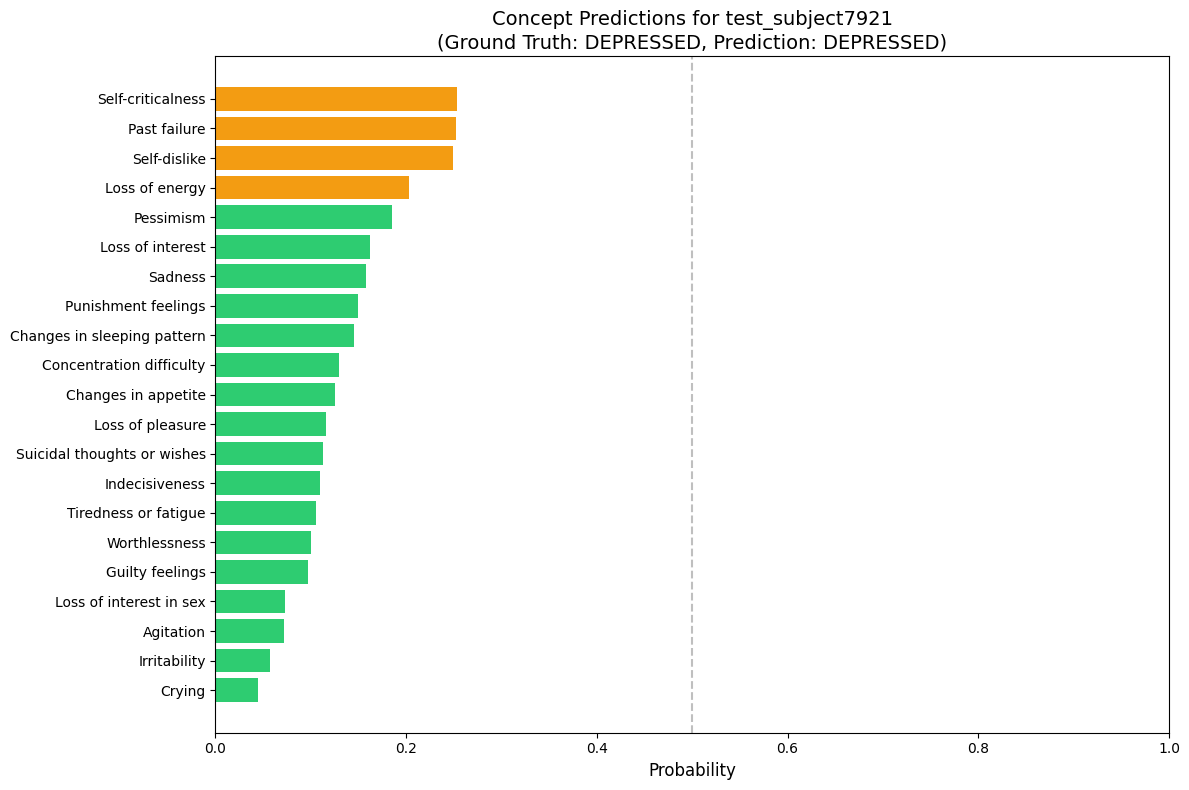

In [27]:
# Concept probability bar chart
plt.figure(figsize=(12, 8))

# Sort by probability
sorted_indices = np.argsort(concept_probabilities)
sorted_concepts = [CONCEPT_NAMES[i] for i in sorted_indices]
sorted_probs = concept_probabilities[sorted_indices]

# Color bars based on probability
colors = ['#2ecc71' if p < 0.2 else '#f39c12' if p < 0.5 else '#e74c3c' for p in sorted_probs]

plt.barh(sorted_concepts, sorted_probs, color=colors)
plt.xlabel('Probability', fontsize=12)
plt.title(f'Concept Predictions for {TARGET_USER}\n(Ground Truth: DEPRESSED, Prediction: {"DEPRESSED" if final_prediction == 1 else "NOT DEPRESSED"})', fontsize=14)
plt.xlim(0, 1)

# Add vertical line at 0.5
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='50% threshold')

plt.tight_layout()
plt.show()

In [28]:
# Summary box
print("\n" + "="*70)
print("PIPELINE SUMMARY")
print("="*70)

print(f"""
USER: {TARGET_USER}

STEP 1: Raw Data
  - Total posts: {len(user_posts)}

STEP 2: Post Retrieval (MAX-based)
  - Selected top-{K_POSTS} posts most relevant to BDI-II concepts
  - MAX similarity range: [{selected_max_scores.min():.4f}, {selected_max_scores.max():.4f}]

STEP 3: Attention Pooling
  - Temperature: {TEMPERATURE}
  - Created 384-dim user embedding

STEP 4: CEM Inference
  - Top 3 Concepts:
    1. {CONCEPT_NAMES[concept_ranking[0]]}: {concept_probabilities[concept_ranking[0]]:.2%}
    2. {CONCEPT_NAMES[concept_ranking[1]]}: {concept_probabilities[concept_ranking[1]]:.2%}
    3. {CONCEPT_NAMES[concept_ranking[2]]}: {concept_probabilities[concept_ranking[2]]:.2%}

FINAL RESULT:
  - Depression Probability: {depression_prob:.4f} ({depression_prob:.1%})
  - Threshold: {DECISION_THRESHOLD}
  - Prediction: {'DEPRESSED' if final_prediction == 1 else 'NOT DEPRESSED'}
  - Ground Truth: {'DEPRESSED' if user_label == 1 else 'NOT DEPRESSED'}
  - Outcome: {'CORRECT' if final_prediction == user_label else 'INCORRECT'}
""")


PIPELINE SUMMARY

USER: test_subject7921

STEP 1: Raw Data
  - Total posts: 229

STEP 2: Post Retrieval (MAX-based)
  - Selected top-50 posts most relevant to BDI-II concepts
  - MAX similarity range: [0.3037, 0.5567]

STEP 3: Attention Pooling
  - Temperature: 0.2
  - Created 384-dim user embedding

STEP 4: CEM Inference
  - Top 3 Concepts:
    1. Self-criticalness: 25.30%
    2. Past failure: 25.21%
    3. Self-dislike: 24.93%

FINAL RESULT:
  - Depression Probability: 0.5079 (50.8%)
  - Threshold: 0.05
  - Prediction: DEPRESSED
  - Ground Truth: DEPRESSED
  - Outcome: CORRECT



In [29]:
# Cleanup
try:
    shutil.rmtree(temp_dir)
    print(f"Cleaned up temporary directory: {temp_dir}")
except Exception as e:
    print(f"Failed to clean up: {e}")

Cleaned up temporary directory: /var/folders/gb/m6c_r5xx6_14p7mlfjwk29900000gn/T/test_chunks_s__al_wu
